<a href="https://colab.research.google.com/github/NilashishDe/Honeywell-Hackathon/blob/main/flightdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost openpyxl

In [3]:
# =====================================
# STEP 1: Import Libraries
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted")


In [7]:
# =====================================
# STEP 2: Load Data
# =====================================
file1 = "6-9flight.xlsx"
file2 = "9-12flight.xlsx"

# Define function to clean each dataset
def clean_flight_data(file_path):
    df = pd.read_excel(
        file_path, header=None, skiprows=1,
        names=['S.No', 'Flight Number', 'Date', 'From', 'To', 'Aircraft', 'Flight time',
               'STD', 'ATD', 'STA', 'col10', 'ATA', 'col12', 'col13']
    )

    # Forward-fill flight numbers and drop empty rows
    df['Flight Number'] = df['Flight Number'].ffill()
    df.dropna(subset=['Date'], inplace=True)
    df.drop(columns=['S.No','col10','col12','col13'], inplace=True)

    # Clean ATA (remove "Landed" etc.)
    def clean_ata(time_str):
        if isinstance(time_str, str) and "Landed" in time_str:
            time_part = time_str.replace("Landed","").strip()
            try:
                return pd.to_datetime(time_part, format="%I:%M %p").strftime("%H:%M:%S")
            except: return None
        elif hasattr(time_str, "strftime"):
            return time_str.strftime("%H:%M:%S")
        return time_str

    df['ATA_cleaned'] = df['ATA'].apply(clean_ata)

    # Convert to datetime
    df['Date'] = pd.to_datetime(df['Date']).dt.date.astype(str)
    df['STA'] = df['STA'].astype(str)
    df['ATA_cleaned'] = df['ATA_cleaned'].astype(str)

    df['STA_datetime'] = pd.to_datetime(df['Date'] + " " + df['STA'], errors="coerce")
    df['ATA_datetime'] = pd.to_datetime(df['Date'] + " " + df['ATA_cleaned'], errors="coerce")

    # Delay calculation
    df['delay_minutes'] = (df['ATA_datetime'] - df['STA_datetime']).dt.total_seconds() / 60
    df['is_delayed'] = df['delay_minutes'].apply(lambda x: 1 if x > 15 else 0)

    # Feature engineering
    df['day_of_week'] = df['STA_datetime'].dt.day_name()
    df['scheduled_hour'] = df['STA_datetime'].dt.hour
    df['Tail Number'] = df['Aircraft'].str.extract(r'\((.*?)\)').fillna('Unknown')
    df['Aircraft Model'] = df['Aircraft'].str.split('(').str[0].str.strip()
    df['To'] = df['To'].str.strip()
    df['From'] = df['From'].str.strip()

    # Final cleaned dataset
    final_df = df[['Flight Number','Date','From','To','Aircraft Model','Tail Number',
                   'STA','day_of_week','scheduled_hour','is_delayed','delay_minutes']].copy()

    return final_df.dropna(subset=['delay_minutes','To','Aircraft Model'])

# Load both files
df1 = clean_flight_data(file1)
df2 = clean_flight_data(file2)

# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)
print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (775, 11)


,Flight Number,Date,From,To,Aircraft Model,Tail Number,STA,day_of_week,scheduled_hour,is_delayed,delay_minutes
0,,2025-07-25,Mumbai (BOM),Chandigarh (IXC),A20N,VT-EXU,08:10:00,Friday,8,0,4.0
1,,2025-07-24,Mumbai (BOM),Chandigarh (IXC),A20N,VT-RTJ,08:10:00,Thursday,8,0,-9.0
2,,2025-07-23,Mumbai (BOM),Chandigarh (IXC),A20N,VT-TQB,08:10:00,Wednesday,8,0,13.0
3,,2025-07-22,Mumbai (BOM),Chandigarh (IXC),A20N,VT-RTU,08:10:00,Tuesday,8,1,70.0
4,,2025-07-21,Mumbai (BOM),Chandigarh (IXC),A20N,VT-EXK,08:10:00,Monday,8,0,-9.0


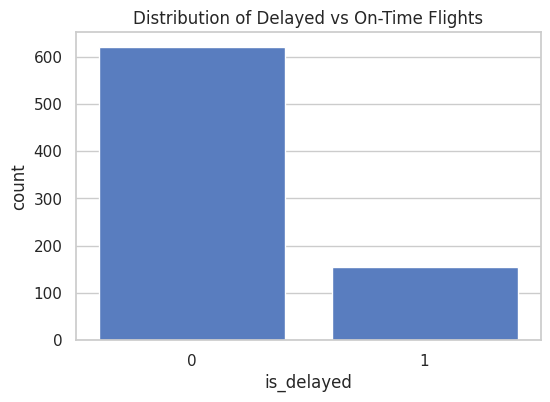

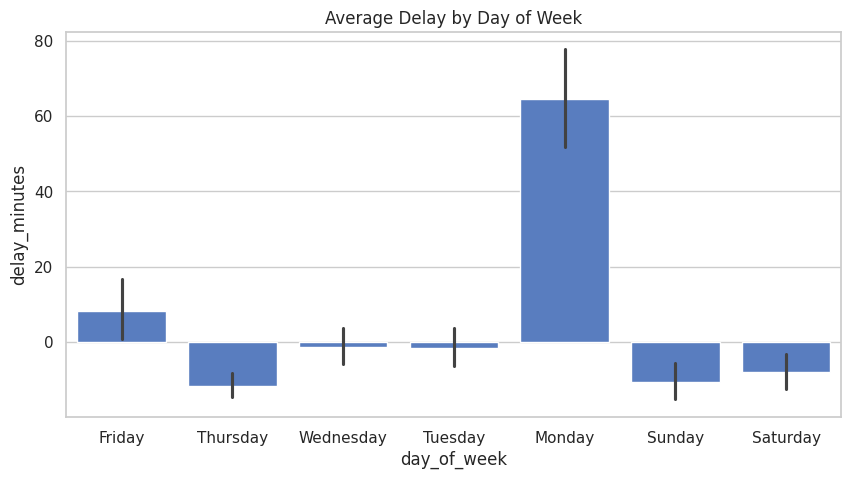

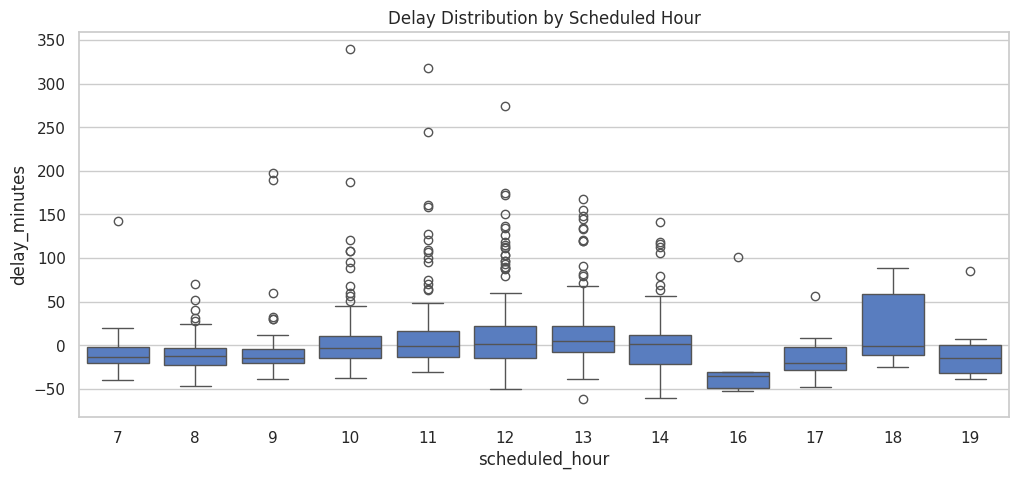

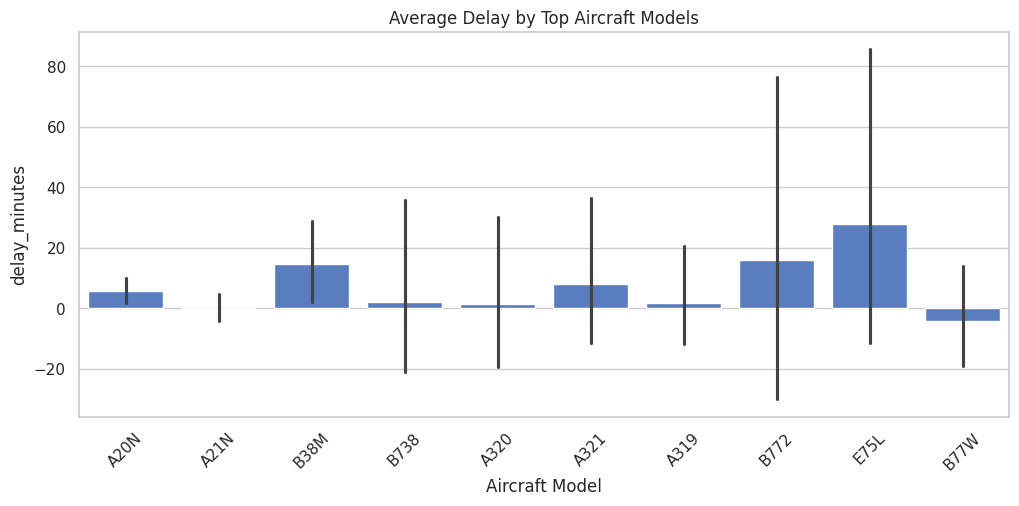

In [8]:
# =====================================
# STEP 3: Exploratory Data Analysis (EDA)
# =====================================

# Distribution of delays
plt.figure(figsize=(6,4))
sns.countplot(x="is_delayed", data=df)
plt.title("Distribution of Delayed vs On-Time Flights")
plt.show()

# Delay by day of week
plt.figure(figsize=(10,5))
sns.barplot(x="day_of_week", y="delay_minutes", data=df, estimator=np.mean)
plt.title("Average Delay by Day of Week")
plt.show()

# Delay by scheduled hour
plt.figure(figsize=(12,5))
sns.boxplot(x="scheduled_hour", y="delay_minutes", data=df)
plt.title("Delay Distribution by Scheduled Hour")
plt.show()

# Delay by aircraft model
top_aircraft = df["Aircraft Model"].value_counts().head(10).index
plt.figure(figsize=(12,5))
sns.barplot(x="Aircraft Model", y="delay_minutes", data=df[df["Aircraft Model"].isin(top_aircraft)], estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Average Delay by Top Aircraft Models")
plt.show()


In [9]:
# =====================================
# STEP 4: Prepare Data for Modeling
# =====================================
features = ["From", "To", "Aircraft Model", "day_of_week", "scheduled_hour"]
target = "is_delayed"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', drop='first'),
                   ["From", "To", "Aircraft Model", "day_of_week"])],
    remainder="passthrough"
)


In [10]:
# =====================================
# STEP 5: Model Training & Comparison
# =====================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

best_model = None
best_score = 0
best_name = ""

print("\n--- Model Comparison ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    print(f"{name}: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_name = name
        best_model = model

print(f"\n🏆 Best Model: {best_name} (CV Accuracy: {best_score:.4f})")



--- Model Comparison ---
Logistic Regression: 0.8645
Decision Tree: 0.8274
Random Forest: 0.8806
Gradient Boosting: 0.8758
XGBoost: 0.8661

🏆 Best Model: Random Forest (CV Accuracy: 0.8806)



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       123
           1       0.91      0.66      0.76        32

    accuracy                           0.92       155
   macro avg       0.91      0.82      0.86       155
weighted avg       0.92      0.92      0.91       155



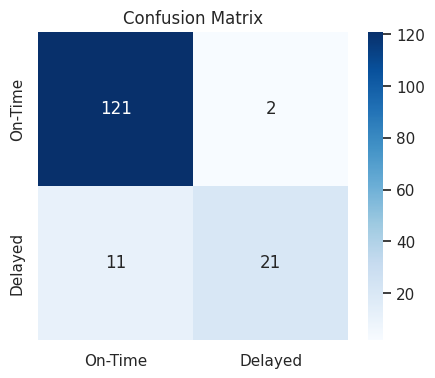

✅ Best model saved as 'flight_delay_model.joblib'


In [11]:
# =====================================
# STEP 6: Train Best Model & Evaluate
# =====================================
best_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", best_model)])
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["On-Time","Delayed"], yticklabels=["On-Time","Delayed"])
plt.title("Confusion Matrix")
plt.show()

# Save Model
joblib.dump(best_pipeline, "flight_delay_model.joblib")
print("✅ Best model saved as 'flight_delay_model.joblib'")


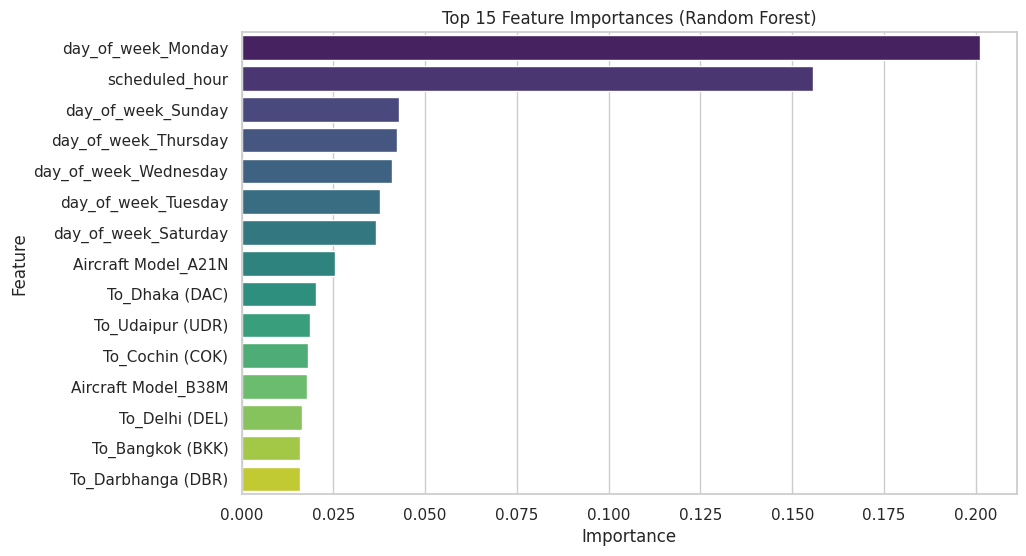

In [12]:
# =====================================
# STEP 7: Feature Importance Analysis
# =====================================

# Refit best model on full training set
best_pipeline.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = list(best_pipeline.named_steps["preprocessor"]
                     .named_transformers_["cat"]
                     .get_feature_names_out(["From", "To", "Aircraft Model", "day_of_week"]))
feature_names += ["scheduled_hour"]

# Extract classifier
clf = best_pipeline.named_steps["classifier"]

# Feature importance (only works for tree-based models)
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
    plt.title(f"Top 15 Feature Importances ({best_name})")
    plt.show()
else:
    print(f"⚠️ {best_name} does not support feature_importances_")


In [19]:
# ✅ Fixed SHAP Explanation Function for new SHAP versions
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_with_shap(best_pipeline, clf, X_train, X_test, best_name, dataset_name="Dataset"):
    """
    Generate SHAP explanations for a trained model and dataset.
    Works for both tree-based and non-tree-based models.
    """

    print(f"\n🔎 Running SHAP for {dataset_name} using {best_name}...\n")

    # Transform test set and ensure numeric array
    X_test_transformed = best_pipeline.named_steps["preprocessor"].transform(X_test)

    # Convert sparse to dense if needed
    if hasattr(X_test_transformed, "toarray"):
        X_test_transformed = X_test_transformed.toarray()

    # Cast to float32
    X_test_transformed = X_test_transformed.astype(np.float32)

    # Get feature names
    feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()

    # Tree-based models (faster + accurate SHAP)
    if best_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer(X_test_transformed)   # ✅ returns Explanation object

        # Add feature names for clarity
        shap_values.feature_names = feature_names

        # Summary plot
        shap.summary_plot(shap_values, feature_names=feature_names)
        plt.show()

        # Bar plot
        shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar")
        plt.show()

    # Other models (fallback: KernelExplainer, slower)
    else:
        explainer = shap.KernelExplainer(
            clf.predict_proba,
            X_test_transformed[:200]  # subset for speed
        )
        shap_values = explainer.shap_values(X_test_transformed[:50])

        shap.summary_plot(
            shap_values, X_test_transformed[:50], feature_names=feature_names
        )
        plt.show()

        shap.summary_plot(
            shap_values, X_test_transformed[:50], feature_names=feature_names, plot_type="bar"
        )
        plt.show()

    print(f"✅ SHAP analysis complete for {dataset_name}\n")



🔎 Running SHAP for Combined dataset using Random Forest...



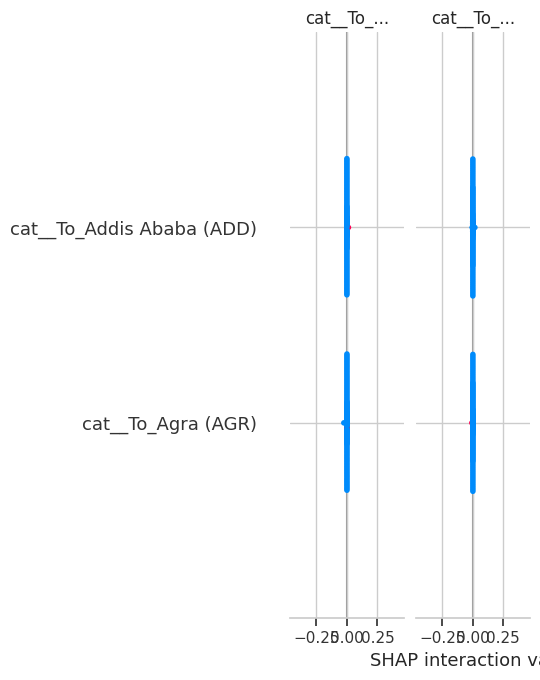

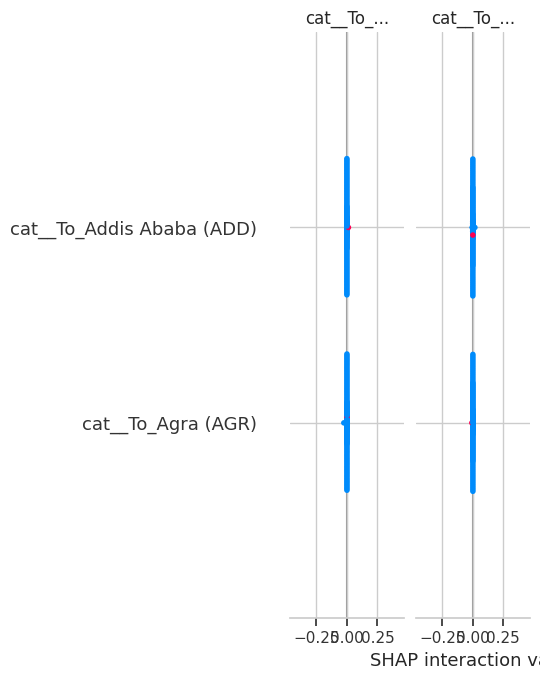

✅ SHAP analysis complete for Combined dataset



In [20]:
explain_with_shap(best_pipeline, best_model, X_train, X_test, best_name, dataset_name="Combined dataset")


📊 Performance Report for Random Forest:
   ✅ Train Accuracy: 0.9984
   ✅ Test Accuracy : 0.9161

📄 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       123
           1       0.91      0.66      0.76        32

    accuracy                           0.92       155
   macro avg       0.91      0.82      0.86       155
weighted avg       0.92      0.92      0.91       155



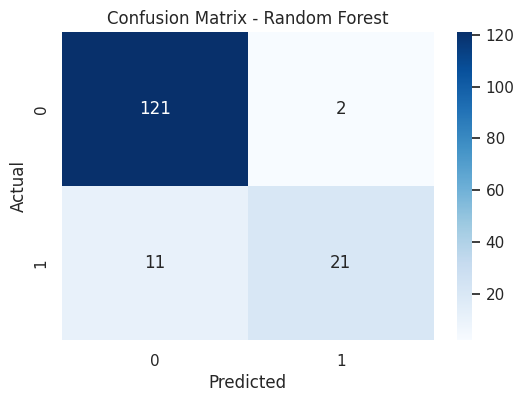

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(best_pipeline, clf, X_train, X_test, y_train, y_test, best_name):
    """
    Evaluate model performance with accuracy, classification report, and confusion matrix.
    """
    # Predictions
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"📊 Performance Report for {best_name}:")
    print(f"   ✅ Train Accuracy: {train_acc:.4f}")
    print(f"   ✅ Test Accuracy : {test_acc:.4f}\n")

    # Classification report (Test Set)
    print("📄 Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {best_name}")
    plt.show()

    return train_acc, test_acc

# Example call
train_acc, test_acc = evaluate_model(best_pipeline, best_model, X_train, X_test, y_train, y_test, best_name)
